In [13]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import pearsonr, zscore, mode
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm

SUBJECT_LIST = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]
PERTURB_AMOUNTS = np.arange(-10, 11) # -10 to 10
BASELINE = 1
STRESS = 2

def load_dict_from_pickle(file_path):
    try:
        # Open the file in binary read mode
        with open(file_path, 'rb') as f:
            # Load the dictionary from the file
            loaded_dict = pickle.load(f)
        #print("Dictionary loaded from pickle file:", file_path)
        return loaded_dict
    except Exception as e:
        print("Error:", e)
        print("Failed to load dictionary from pickle file.")
    return None

def remove_features(feature_dict, features_to_remove):
    # Get indices of features to remove
    remove_feature_indices = np.where(np.isin(feature_dict['feature_names'], features_to_remove))
    
    # Remove them
    features = np.delete(feature_dict['features'], remove_feature_indices, axis=1)
    feature_names = np.delete(feature_dict['feature_names'], remove_feature_indices)
    
    # Create a new dict with the features removed
    new_feature_dict = {'features': features, 'feature_names': feature_names, 'labels': feature_dict['labels'], 'subject': feature_dict['subject']}
    return new_feature_dict

def train_test_split_LOOCV_binary(feature_dict, test_subject):
    '''
    Given the feature dict containing features for all of the subjects, 
    and the subject to leave out (test_subject), splits the data 
    into train and test data for Leave One Out Cross-Validation (LOOCV).
    
    Removes the amusement condition (labels == 3) to make this a binary classification problem.
    
    Returns:
    X_train, X_test, y_train, y_test (train data, test data, train labels, test labels)
    '''
    
    features = feature_dict['features']
    labels = feature_dict['labels']
    train_indices = np.where((np.array(feature_dict['subject']) != test_subject) & (labels != 3))[0]
    test_indices = np.where((np.array(feature_dict['subject']) == test_subject) & (labels != 3))[0]
    
    # Yell at is if there is any overlap, just in case
    if np.any(np.isin(train_indices, test_indices)):
        print("NO! Train and test overlap!!!!!!")
        
    return features[train_indices], features[test_indices], labels[train_indices], labels[test_indices]

def perturb_feature_by_amount(array, column_index, amount):
    perturbed_array = array.copy()
    perturbed_array[:, column_index] += amount
    return perturbed_array

# Load data
file_path_zscored_by_sub = f"features/combined/feature_dict_zscored_by_sub.pkl"
feature_dict = load_dict_from_pickle(file_path_zscored_by_sub)

# Features to remove in the first pass based on domain knowledge and correlations.
features_to_remove_1 = ['ACC x mean', 'ACC y mean', 'ACC z mean', 'ACC mean', 'ACC x std', 'ACC y std',
                    'ACC z std', 'ACC std', 'ACC abs integral x', 'ACC abs integral y', 'ACC abs integral z',
                    'ACC peak frequency x', 'ACC peak frequency y', 'ACC peak frequency z', 
                    'EMG dynamic range', 'EMG absolute integral','EMG 10th percentile', 'EMG 90th percentile','EMG peak frequency', 'EMG std peak amplitude', 
                    'EMG sum peak amplitudes', 'EMG normalized sum peak amplitudes', 'Respiration duration',
                    'Temp min', 'Temp max', 'Temp dynamic range', 'EDA std', 'EDA min', 'EDA max', 'EDA dynamic range', 
                    'Sum of response durations', 'HRV mean', 'HRV RMS', 'nn50', 'pnn50', 'ECG HF energy']

# Remove features
feature_dict = remove_features(feature_dict, features_to_remove_1)

15it [00:05,  2.95it/s]


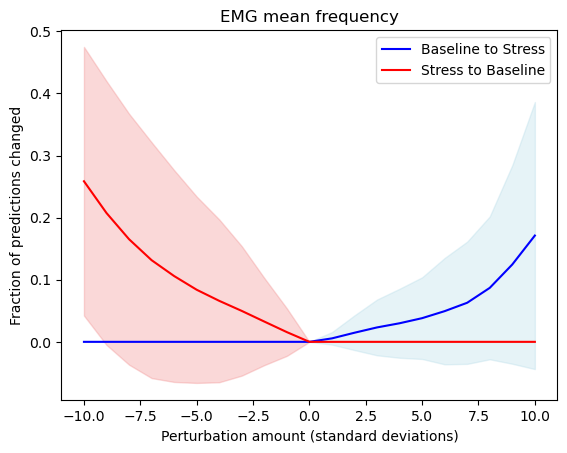

In [110]:
# Investigate how perturbing a given feature changes our predictions.
feature_to_perturb = 3
feature_name = feature_dict['feature_names'][feature_to_perturb]

pred_changed_base_to_stress = np.zeros((len(PERTURB_AMOUNTS), len(SUBJECT_LIST)))
pred_changed_stress_to_base = np.zeros((len(PERTURB_AMOUNTS), len(SUBJECT_LIST)))
    
# Do this for all test subjects (LOOCV)
for s, test_sub in tqdm(enumerate(SUBJECT_LIST)):
    # Split the data into training and testing sets by subject
    X_train, X_test, y_train, y_test = train_test_split_LOOCV_binary(feature_dict, test_sub)
    
    # Fit the model using training data
    model = LinearDiscriminantAnalysis()
    model.fit(X_train, y_train)

    # Make predictions on the original test data
    y_pred = model.predict(X_test)
    
    for i, perturb_amount in enumerate(PERTURB_AMOUNTS):
        # Make predictions on the perturbed test data
        perturbed_X_test = perturb_feature_by_amount(X_test, feature_to_perturb, perturb_amount)
        perturbed_y_pred = model.predict(perturbed_X_test)
        # If (perturbed - regular) = 1, we went baseline to stress; if -1 we went stress to baseline
        pred_diffs = perturbed_y_pred - y_pred
        # Normalize by the number of predictions originally in that category
        pred_changed_base_to_stress[i, s] = np.count_nonzero(pred_diffs == 1)/np.count_nonzero(y_pred == BASELINE)
        pred_changed_stress_to_base[i, s] = np.count_nonzero(pred_diffs == -1)/np.count_nonzero(y_pred == STRESS)

# Report mean and std across all subjects
mean_base2stress = np.mean(pred_changed_base_to_stress, axis=1)
std_base2stress = np.std(pred_changed_base_to_stress, axis=1)
mean_stress2base = np.mean(pred_changed_stress_to_base, axis=1)
std_stress2base = np.std(pred_changed_stress_to_base, axis=1)

# Plot baseline to stress and stress to baseline. Shade area around mean to show standard deviation
plt.plot(PERTURB_AMOUNTS, mean_base2stress, color='blue', label='Baseline to Stress')
plt.fill_between(PERTURB_AMOUNTS, mean_base2stress - std_base2stress, mean_base2stress + std_base2stress, color='lightblue', alpha=0.3)
plt.plot(PERTURB_AMOUNTS, mean_stress2base, color='red', label='Stress to Baseline')
plt.fill_between(PERTURB_AMOUNTS, mean_stress2base - std_stress2base, mean_stress2base + std_stress2base, color='lightcoral', alpha=0.3)
plt.title(feature_name)
plt.xlabel("Perturbation amount (standard deviations)")
plt.ylabel("Fraction of predictions changed")
plt.legend()
plt.show()

In [25]:
def generate_all_index_perturbations(original_array, amount):
    """
    Generate every possible combination of perturbations for every index of an array by a single amount.

    Returns an array of perturbed arrays, each representing a unique perturbation combination.
    """
    # Generate perturbation combinations for each index
    perturbation_combos = list(product([0, amount], repeat=len(original_array)))

    # Generate all possible perturbed arrays
    perturbed_arrays = []
    for combo in perturbation_combos:
        perturbed_array = original_array + np.array(combo)
        perturbed_arrays.append(perturbed_array)

    return np.array(perturbed_arrays)

# Define the original array
original_array = np.array([0, 0, 0, 0])

# Define the perturbation amount
amount = 2

# Generate every possible combination of perturbations for every index by the single amount
all_index_perturbations = generate_all_index_perturbations(original_array, amount)

# Print the resulting outputs
for perturbed_array in all_index_perturbations:
    print(perturbed_array)

[0 0 0 0]
[0 0 0 2]
[0 0 2 0]
[0 0 2 2]
[0 2 0 0]
[0 2 0 2]
[0 2 2 0]
[0 2 2 2]
[2 0 0 0]
[2 0 0 2]
[2 0 2 0]
[2 0 2 2]
[2 2 0 0]
[2 2 0 2]
[2 2 2 0]
[2 2 2 2]
